# Task-level Performance Quantification

This notebook analyses the utility of assessors for predicting performance at the task level by aggregating instance level predictions, i.e. it does a predict-then-count quantization. We compare to using the models self-assessed confidence and just using the mean.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from typing import *
from pathlib import Path
from dataclasses import dataclass
import math

from transformers.models.auto.modeling_auto import AutoModelForSequenceClassification
from transformers.models.auto.tokenization_auto import AutoTokenizer
from transformers.trainer import Trainer
import scipy.special as sc_special
import numpy as np
import pandas as pd
import bigbench.api.results as bb

from lass.log_handling import LogLoader
from lass.datasets import split_task_level, huggingfaceify
import lass
import lass.metrics.pandas

Couldn't find a directory or a metric named 'roc_auc' in this version. It was picked from the master branch on github instead.


In [4]:
loader = (LogLoader(logdir = Path('../artifacts/logs'))
        .with_tasks('paper-full')
        .with_model_families(['BIG-G T=0'])
        .with_model_sizes(['128b'])
        .with_shots([0])
        .with_query_types([bb.MultipleChoiceQuery])
)

_train, test = split_task_level(loader, seed=42, test_fraction=0.2)

In [5]:
import transformers
%env TOKENIZERS_PARALLELISM=true

dataset = huggingfaceify(_train[:1], test)


env: TOKENIZERS_PARALLELISM=true


In [6]:
transformers.logging.set_verbosity_error() # type: ignore
model = AutoModelForSequenceClassification.from_pretrained("../artifacts/assessors/albert-bs32-0sh-task-split/checkpoint-1500")

# Tokenize according to specific model tokenizer
tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")
def tokenize(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, return_tensors="np")
tokenized_datasets = dataset.map(tokenize, batched=True)

# Dummy Trainer for easy batched predictions
dummy_trainer = Trainer(model=model)

predictions, labels, metrics = dummy_trainer.predict(tokenized_datasets['test']) #type: ignore


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/9 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 8986
  Batch size = 8
/home/wout/pp/lass/.env/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [7]:
df = test.copy()
df = df[df['correct'].isin([0.0, 1.0])]

df['assr_conf']= sc_special.softmax(predictions, axis=-1)[:, -1] # Softmax and take success prob
df['lm_conf_normalized'] = df.apply(lambda row: math.exp(np.max(row['normalized_scores'])), axis=1)
df['lm_conf_absolute'] = df.apply(lambda row: math.exp(np.max(row['absolute_scores'])), axis=1)

# Group by task
perfs = df.groupby('task').agg({
    'assr_conf': 'mean',
    'lm_conf_normalized': 'mean',
    'lm_conf_absolute': 'mean',
    'correct': 'mean'
})
perfs

,assr_conf,lm_conf_normalized,lm_conf_absolute,correct
task,,,,
cause_and_effect,0.430424,0.850228,0.115619,0.673203
checkmate_in_one,0.182302,0.586714,0.000016,0.004883
cifar10_classification,0.183313,0.390550,0.211644,0.101562
common_morpheme,0.307563,0.744003,0.006946,0.320000
cryobiology_spanish,0.389640,0.803192,0.119684,0.636986
cs_algorithms,0.445052,0.587033,0.070153,0.296875
emoji_movie,0.370966,0.549358,0.131002,0.320000
emojis_emotion_prediction,0.292092,0.331735,0.118214,0.250000
english_russian_proverbs,0.315421,0.773879,0.010380,0.300000


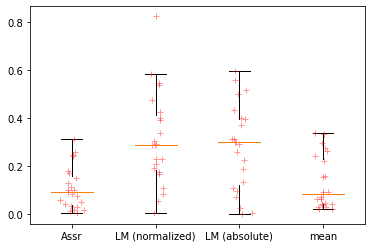

In [13]:
import matplotlib.pyplot as plt

def mse(confs):
    return (perfs['correct'] - confs)**2

def me(confs):
    return abs(perfs['correct'] - confs)

bp = plt.boxplot([
    me(perfs['assr_conf']), 
    me(perfs['lm_conf_normalized']), 
    me(perfs['lm_conf_absolute']),
    me(_train['correct'].mean())
], labels=[
    'Assr',
    'LM (normalized)', 
    'LM (absolute)',
    'mean'
],
    showbox=False, widths=0.5, showfliers=False
)

jitter = [np.random.normal(1+i, 0.07, size=len(perfs)) for i in range(0,4)]
_ = plt.plot(
    jitter,
    [me(perfs['assr_conf']), me(perfs['lm_conf_normalized']), me(perfs['lm_conf_absolute']), me(_train['correct'].mean())],
     'r+', alpha=0.4
)


In [18]:
from scipy.stats import pearsonr

print(pearsonr(me(perfs['assr_conf']),  me(_train['correct'].mean())))

pd.DataFrame([{
    'name': 'assr',
    'mse': mse(perfs['assr_conf']).mean(),
    'me': me(perfs['assr_conf']).mean(),
}, {
    'name': 'lm_normalized',
    'mse': mse(perfs['lm_conf_normalized']).mean(),
    'me': me(perfs['lm_conf_normalized']).mean(),
}, {
    'name': 'lm_absolute',
    'mse': mse(perfs['lm_conf_absolute']).mean(),
    'me': me(perfs['lm_conf_absolute']).mean(),
}, {
    'name': 'mean',
    'mse': mse(_train['correct'].mean()).mean(),
    'me': me(_train['correct'].mean()).mean(),
}])

(0.5915863078715249, 0.002946078092444128)


,name,mse,me
0,assr,0.019569,0.109654
1,lm_normalized,0.132380,0.310256
2,lm_absolute,0.107586,0.277736
3,mean,0.028601,0.130851
